In [1]:
import torch
import RETFound_MAE.models_vit
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from functools import partial
from pathlib import Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from RETFound_MAE.util.pos_embed import interpolate_pos_embed
from timm.models.layers import trunc_normal_
from torch.nn import Linear, ReLU, CrossEntropyLoss
import timm


In [2]:
class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)
        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)
            del self.norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome

    def forward_head(self, x, pre_logits: bool = False):
        if self.global_pool:
            x = self.fc_norm(x)
        if pre_logits:
            return x
        x = self.head(x)
        return x

def vit_large_patch16(global_pool=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), global_pool=global_pool, **kwargs)
    return model

model_R = vit_large_patch16(num_classes=5, drop_path_rate=0.2, global_pool=True)

In [13]:
checkpoint = torch.load('RETFound_cfp_weights.pth', map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model_R.state_dict()

for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

interpolate_pos_embed(model_R, checkpoint_model)

msg = model_R.load_state_dict(checkpoint_model, strict=False)
assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}

trunc_normal_(model_R.head.weight, std=2e-5)

data_dir = Path('IDRiD')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir / 'train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir / 'test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_R.to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model_R.parameters(), lr=1e-4)

num_epochs = 100
best_test_acc = 0.0

In [22]:
for epoch in range(num_epochs):
    model_R.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model_R(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i+1) % 10 == 0:
            print(f"  Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    model_R.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model_R(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model_R.state_dict(), 'best_model.pth')

model_R.load_state_dict(torch.load('best_model.pth'))
model_R.eval()

test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model_R(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/100
  Batch 10/87, Loss: 0.0021
  Batch 20/87, Loss: 0.1801
  Batch 30/87, Loss: 0.0069
  Batch 40/87, Loss: 0.0017
  Batch 50/87, Loss: 0.0022
  Batch 60/87, Loss: 0.0044
  Batch 70/87, Loss: 0.0025
  Batch 80/87, Loss: 0.0016
Epoch 1/100, Train Loss: 0.0583, Train Acc: 0.9884, Test Loss: 4.2422, Test Acc: 0.4809
Epoch 2/100
  Batch 10/87, Loss: 0.0002
  Batch 20/87, Loss: 0.0044
  Batch 30/87, Loss: 0.7273
  Batch 40/87, Loss: 0.0616
  Batch 50/87, Loss: 0.1504
  Batch 60/87, Loss: 0.0123
  Batch 70/87, Loss: 0.0241
  Batch 80/87, Loss: 0.0577
Epoch 2/100, Train Loss: 0.2294, Train Acc: 0.9391, Test Loss: 3.9293, Test Acc: 0.3282
Epoch 3/100
  Batch 10/87, Loss: 0.9250
  Batch 20/87, Loss: 0.0078
  Batch 30/87, Loss: 0.0125
  Batch 40/87, Loss: 0.0638
  Batch 50/87, Loss: 0.5882
  Batch 60/87, Loss: 1.5468
  Batch 70/87, Loss: 0.5626
  Batch 80/87, Loss: 0.0301
Epoch 3/100, Train Loss: 0.3557, Train Acc: 0.9159, Test Loss: 3.2651, Test Acc: 0.3740
Epoch 4/100
  Batch 10/87, L

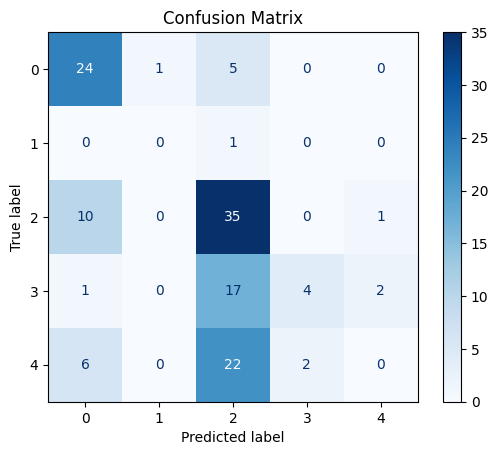

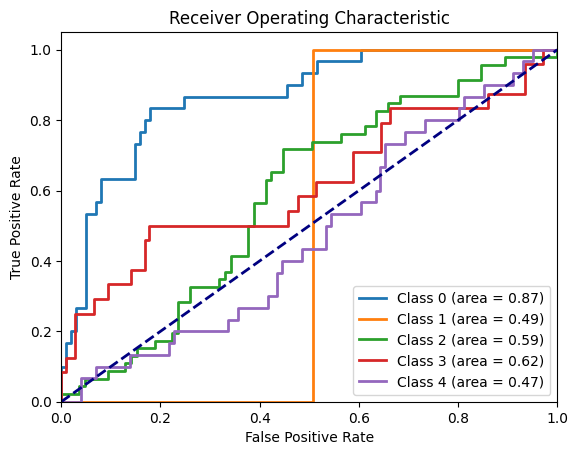

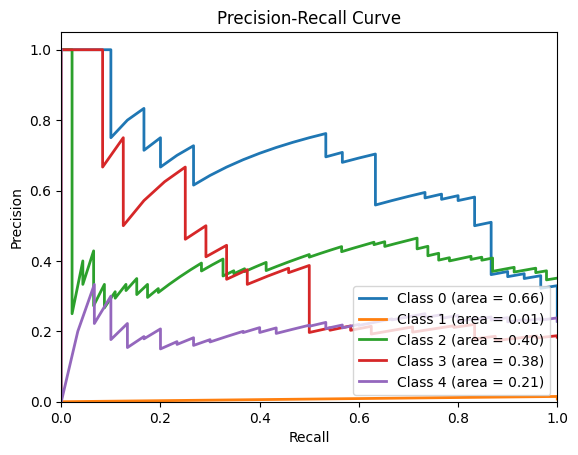

In [23]:
cm = confusion_matrix(all_labels, np.argmax(all_preds, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

for i in range(5):
    fpr, tpr, _ = roc_curve(all_labels == i, all_preds[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

for i in range(5):
    precision, recall, _ = precision_recall_curve(all_labels == i, all_preds[:, i])
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, lw=2, label=f'Class {i} (area = {pr_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()
